In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.5 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 33287 
    Total predicted counts          : 33265.66
    Total off counts                : 101681.00

    Total background counts         : 20336.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 30.9 s, sys: 188 ms, total: 31.1 s
Wall time: 31.2 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 33357 
    Total predicted counts          : 33342.46
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 32889 
    Total predicted counts          : 33263.86
    Total off counts                : 101672.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_13 

    Total counts                    : 33171 
    Total predicted counts          : 33328.06
    Total off counts                : 101993.00

    Total background counts         : 20398.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_14 

    Total counts                    : 33626 
    Total predicted counts          : 33342.06
    Total off counts                : 102063.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_33 

    Total counts                    : 33515 
    Total predicted counts          : 33278.46
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_34 

    Total counts                    : 33495 
    Total predicted counts          : 33203.26
    Total off counts                : 101369.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_52 

    Total counts                    : 33249 
    Total predicted counts          : 33290.06
    Total off counts                : 101803.00

    Total background counts         : 20360.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_53 

    Total counts                    : 33240 
    Total predicted counts          : 33315.46
    Total off counts                : 101930.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_71 

    Total counts                    : 33336 
    Total predicted counts          : 33176.86
    Total off counts                : 101237.00

    Total background counts         : 20247.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_72 

    Total counts                    : 33031 
    Total predicted counts          : 33216.06
    Total off counts                : 101433.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_88 

    Total counts                    : 33013 
    Total predicted counts          : 33203.66
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 32842 
    Total predicted counts          : 33074.06
    Total off counts                : 100723.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_105 

    Total counts                    : 33168 
    Total predicted counts          : 33258.26
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_106 

    Total counts                    : 33301 
    Total predicted counts          : 33270.66
    Total off counts                : 101706.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_125 

    Total counts                    : 33456 
    Total predicted counts          : 33135.86
    Total off counts                : 101032.00

    Total background counts         : 20206.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_126 

    Total counts                    : 33185 
    Total predicted counts          : 33159.66
    Total off counts                : 101151.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_144 

    Total counts                    : 33275 
    Total predicted counts          : 33220.86
    Total off counts                : 101457.00

    Total background counts         : 20291.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_145 

    Total counts                    : 33257 
    Total predicted counts          : 33345.66
    Total off counts                : 102081.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 33215 
    Total predicted counts          : 33242.26
    Total off counts                : 101564.00

    Total background counts         : 20312.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_163 

    Total counts                    : 33170 
    Total predicted counts          : 33254.46
    Total off counts                : 101625.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_177 

    Total counts                    : 33444 
    Total predicted counts          : 33140.06
    Total off counts                : 101053.00

    Total background counts         : 20210.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_178 

    Total counts                    : 33154 
    Total predicted counts          : 33277.26
    Total off counts                : 101739.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_192 

    Total counts                    : 33103 
    Total predicted counts          : 33242.66
    Total off counts                : 101566.00

    Total background counts         : 20313.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 33193 
    Total predicted counts          : 33155.06
    Total off counts                : 101128.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_212 

    Total counts                    : 33029 
    Total predicted counts          : 33322.86
    Total off counts                : 101967.00

    Total background counts         : 20393.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_213 

    Total counts                    : 33121 
    Total predicted counts          : 33188.86
    Total off counts                : 101297.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_232 

    Total counts                    : 33277 
    Total predicted counts          : 33195.66
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_233 

    Total counts                    : 33064 
    Total predicted counts          : 33212.86
    Total off counts                : 101417.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_251 

    Total counts                    : 33181 
    Total predicted counts          : 33258.26
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_252 

    Total counts                    : 33243 
    Total predicted counts          : 33296.86
    Total off counts                : 101837.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_271 

    Total counts                    : 33151 
    Total predicted counts          : 33302.46
    Total off counts                : 101865.00

    Total background counts         : 20373.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_272 

    Total counts                    : 33346 
    Total predicted counts          : 33260.46
    Total off counts                : 101655.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_289 

    Total counts                    : 32935 
    Total predicted counts          : 33064.26
    Total off counts                : 100674.00

    Total background counts         : 20134.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_290 

    Total counts                    : 33053 
    Total predicted counts          : 33153.26
    Total off counts                : 101119.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 33279 
    Total predicted counts          : 33225.06
    Total off counts                : 101478.00

    Total background counts         : 20295.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_309 

    Total counts                    : 33474 
    Total predicted counts          : 33249.06
    Total off counts                : 101598.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_325 

    Total counts                    : 33471 
    Total predicted counts          : 33211.06
    Total off counts                : 101408.00

    Total background counts         : 20281.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_326 

    Total counts                    : 33423 
    Total predicted counts          : 33220.26
    Total off counts                : 101454.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_345 

    Total counts                    : 33102 
    Total predicted counts          : 33273.86
    Total off counts                : 101722.00

    Total background counts         : 20344.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_346 

    Total counts                    : 33395 
    Total predicted counts          : 33138.46
    Total off counts                : 101045.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_357 

    Total counts                    : 33278 
    Total predicted counts          : 33147.66
    Total off counts                : 101091.00

    Total background counts         : 20218.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 33348 
    Total predicted counts          : 33206.86
    Total off counts                : 101387.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 32866 
    Total predicted counts          : 33284.26
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 33195 
    Total predicted counts          : 33290.06
    Total off counts                : 101803.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 33081 
    Total predicted counts          : 33255.46
    Total off counts                : 101630.00

    Total background counts         : 20326.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_397 

    Total counts                    : 33101 
    Total predicted counts          : 33193.66
    Total off counts                : 101321.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_415 

    Total counts                    : 33308 
    Total predicted counts          : 33256.06
    Total off counts                : 101633.00

    Total background counts         : 20326.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_416 

    Total counts                    : 32943 
    Total predicted counts          : 33186.66
    Total off counts                : 101286.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_434 

    Total counts                    : 33294 
    Total predicted counts          : 33236.86
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_435 

    Total counts                    : 33381 
    Total predicted counts          : 33132.66
    Total off counts                : 101016.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 33623 
    Total predicted counts          : 33276.86
    Total off counts                : 101737.00

    Total background counts         : 20347.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_455 

    Total counts                    : 32902 
    Total predicted counts          : 33178.06
    Total off counts                : 101243.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_473 

    Total counts                    : 33376 
    Total predicted counts          : 33258.06
    Total off counts                : 101643.00

    Total background counts         : 20328.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 33265 
    Total predicted counts          : 33310.66
    Total off counts                : 101906.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_492 

    Total counts                    : 32998 
    Total predicted counts          : 33341.46
    Total off counts                : 102060.00

    Total background counts         : 20412.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_493 

    Total counts                    : 33396 
    Total predicted counts          : 33301.26
    Total off counts                : 101859.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_511 

    Total counts                    : 32968 
    Total predicted counts          : 33218.26
    Total off counts                : 101444.00

    Total background counts         : 20288.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_512 

    Total counts                    : 32940 
    Total predicted counts          : 33105.26
    Total off counts                : 100879.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_530 

    Total counts                    : 33244 
    Total predicted counts          : 33203.06
    Total off counts                : 101368.00

    Total background counts         : 20273.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_531 

    Total counts                    : 33434 
    Total predicted counts          : 33128.66
    Total off counts                : 100996.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_549 

    Total counts                    : 33317 
    Total predicted counts          : 33227.06
    Total off counts                : 101488.00

    Total background counts         : 20297.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_550 

    Total counts                    : 33023 
    Total predicted counts          : 33176.66
    Total off counts                : 101236.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 33279 
    Total predicted counts          : 33226.86
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 33552 
    Total predicted counts          : 33254.06
    Total off counts                : 101623.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_587 

    Total counts                    : 33233 
    Total predicted counts          : 33251.86
    Total off counts                : 101612.00

    Total background counts         : 20322.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_588 

    Total counts                    : 33126 
    Total predicted counts          : 33272.46
    Total off counts                : 101715.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 33605 
    Total predicted counts          : 33321.86
    Total off counts                : 101962.00

    Total background counts         : 20392.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_607 

    Total counts                    : 33295 
    Total predicted counts          : 33190.26
    Total off counts                : 101304.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 32774 
    Total predicted counts          : 33251.06
    Total off counts                : 101608.00

    Total background counts         : 20321.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_626 

    Total counts                    : 33044 
    Total predicted counts          : 33195.66
    Total off counts                : 101331.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 33125 
    Total predicted counts          : 33281.66
    Total off counts                : 101761.00

    Total background counts         : 20352.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 33266 
    Total predicted counts          : 33303.06
    Total off counts                : 101868.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_663 

    Total counts                    : 33202 
    Total predicted counts          : 33190.86
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 33032 
    Total predicted counts          : 33093.26
    Total off counts                : 100819.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_682 

    Total counts                    : 33370 
    Total predicted counts          : 33280.46
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_683 

    Total counts                    : 33043 
    Total predicted counts          : 33202.46
    Total off counts                : 101365.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_699 

    Total counts                    : 33433 
    Total predicted counts          : 33195.66
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_700 

    Total counts                    : 33144 
    Total predicted counts          : 33401.46
    Total off counts                : 102360.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_719 

    Total counts                    : 33492 
    Total predicted counts          : 33358.66
    Total off counts                : 102146.00

    Total background counts         : 20429.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_720 

    Total counts                    : 33313 
    Total predicted counts          : 33164.26
    Total off counts                : 101174.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_735 

    Total counts                    : 33309 
    Total predicted counts          : 33227.66
    Total off counts                : 101491.00

    Total background counts         : 20298.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_736 

    Total counts                    : 32989 
    Total predicted counts          : 33347.66
    Total off counts                : 102091.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 33297 
    Total predicted counts          : 33200.86
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_754 

    Total counts                    : 33523 
    Total predicted counts          : 33188.46
    Total off counts                : 101295.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_771 

    Total counts                    : 33332 
    Total predicted counts          : 33125.66
    Total off counts                : 100981.00

    Total background counts         : 20196.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_772 

    Total counts                    : 33303 
    Total predicted counts          : 33187.66
    Total off counts                : 101291.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_791 

    Total counts                    : 33401 
    Total predicted counts          : 33161.06
    Total off counts                : 101158.00

    Total background counts         : 20231.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_792 

    Total counts                    : 32994 
    Total predicted counts          : 33180.66
    Total off counts                : 101256.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_809 

    Total counts                    : 33195 
    Total predicted counts          : 33308.86
    Total off counts                : 101897.00

    Total background counts         : 20379.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_810 

    Total counts                    : 33352 
    Total predicted counts          : 33184.86
    Total off counts                : 101277.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_829 

    Total counts                    : 32981 
    Total predicted counts          : 33165.26
    Total off counts                : 101179.00

    Total background counts         : 20235.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 33351 
    Total predicted counts          : 33186.06
    Total off counts                : 101283.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_847 

    Total counts                    : 33360 
    Total predicted counts          : 33175.26
    Total off counts                : 101229.00

    Total background counts         : 20245.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_848 

    Total counts                    : 33304 
    Total predicted counts          : 33217.26
    Total off counts                : 101439.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_866 

    Total counts                    : 33300 
    Total predicted counts          : 33287.06
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_867 

    Total counts                    : 33362 
    Total predicted counts          : 33217.06
    Total off counts                : 101438.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_886 

    Total counts                    : 33138 
    Total predicted counts          : 33209.26
    Total off counts                : 101399.00

    Total background counts         : 20279.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_887 

    Total counts                    : 33305 
    Total predicted counts          : 33172.46
    Total off counts                : 101215.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_905 

    Total counts                    : 33127 
    Total predicted counts          : 33310.66
    Total off counts                : 101906.00

    Total background counts         : 20381.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_906 

    Total counts                    : 33491 
    Total predicted counts          : 33237.06
    Total off counts                : 101538.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_923 

    Total counts                    : 33196 
    Total predicted counts          : 33278.46
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_924 

    Total counts                    : 33345 
    Total predicted counts          : 33211.26
    Total off counts                : 101409.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_942 

    Total counts                    : 33093 
    Total predicted counts          : 33226.06
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_943 

    Total counts                    : 33340 
    Total predicted counts          : 33258.66
    Total off counts                : 101646.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_961 

    Total counts                    : 33357 
    Total predicted counts          : 33201.66
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_962 

    Total counts                    : 33120 
    Total predicted counts          : 33247.46
    Total off counts                : 101590.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_980 

    Total counts                    : 33411 
    Total predicted counts          : 33287.06
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_981 

    Total counts                    : 33474 
    Total predicted counts          : 33253.26
    Total off counts                : 101619.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_999 

    Total counts                    : 33119 
    Total predicted counts          : 33241.46
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1000 

    Total counts                    : 33555 
    Total predicted counts          : 33309.66
    Total off counts                : 101901.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1017 

    Total counts                    : 33331 
    Total predicted counts          : 33178.46
    Total off counts                : 101245.00

    Total background counts         : 20249.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1018 

    Total counts                    : 33156 
    Total predicted counts          : 33143.86
    Total off counts                : 101072.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1036 

    Total counts                    : 33286 
    Total predicted counts          : 33277.26
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1037 

    Total counts                    : 33237 
    Total predicted counts          : 33384.86
    Total off counts                : 102277.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1054 

    Total counts                    : 33766 
    Total predicted counts          : 33136.46
    Total off counts                : 101035.00

    Total background counts         : 20207.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1055 

    Total counts                    : 32989 
    Total predicted counts          : 33241.26
    Total off counts                : 101559.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1073 

    Total counts                    : 33167 
    Total predicted counts          : 33163.46
    Total off counts                : 101170.00

    Total background counts         : 20234.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1074 

    Total counts                    : 33260 
    Total predicted counts          : 33255.86
    Total off counts                : 101632.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1089 

    Total counts                    : 32973 
    Total predicted counts          : 33136.66
    Total off counts                : 101036.00

    Total background counts         : 20207.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1090 

    Total counts                    : 32843 
    Total predicted counts          : 33346.46
    Total off counts                : 102085.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1104 

    Total counts                    : 33544 
    Total predicted counts          : 33319.86
    Total off counts                : 101952.00

    Total background counts         : 20390.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1105 

    Total counts                    : 33202 
    Total predicted counts          : 33111.06
    Total off counts                : 100908.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1119 

    Total counts                    : 32988 
    Total predicted counts          : 33218.46
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1120 

    Total counts                    : 33055 
    Total predicted counts          : 33271.26
    Total off counts                : 101709.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1131 

    Total counts                    : 32888 
    Total predicted counts          : 33301.26
    Total off counts                : 101859.00

    Total background counts         : 20371.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1132 

    Total counts                    : 33397 
    Total predicted counts          : 33121.66
    Total off counts                : 100961.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1144 

    Total counts                    : 32994 
    Total predicted counts          : 33269.46
    Total off counts                : 101700.00

    Total background counts         : 20340.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1145 

    Total counts                    : 33325 
    Total predicted counts          : 33259.26
    Total off counts                : 101649.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1158 

    Total counts                    : 33171 
    Total predicted counts          : 33215.46
    Total off counts                : 101430.00

    Total background counts         : 20286.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1159 

    Total counts                    : 33177 
    Total predicted counts          : 33256.26
    Total off counts                : 101634.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1176 

    Total counts                    : 33189 
    Total predicted counts          : 33279.06
    Total off counts                : 101748.00

    Total background counts         : 20349.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1177 

    Total counts                    : 33242 
    Total predicted counts          : 33275.46
    Total off counts                : 101730.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1193 

    Total counts                    : 33018 
    Total predicted counts          : 33203.46
    Total off counts                : 101370.00

    Total background counts         : 20274.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1194 

    Total counts                    : 33415 
    Total predicted counts          : 33234.46
    Total off counts                : 101525.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1214 

    Total counts                    : 33412 
    Total predicted counts          : 33235.06
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1215 

    Total counts                    : 33233 
    Total predicted counts          : 33223.26
    Total off counts                : 101469.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1233 

    Total counts                    : 33458 
    Total predicted counts          : 33243.26
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1234 

    Total counts                    : 33089 
    Total predicted counts          : 33216.46
    Total off counts                : 101435.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1253 

    Total counts                    : 33472 
    Total predicted counts          : 33129.46
    Total off counts                : 101000.00

    Total background counts         : 20200.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1254 

    Total counts                    : 33555 
    Total predicted counts          : 33147.86
    Total off counts                : 101092.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1273 

    Total counts                    : 33308 
    Total predicted counts          : 33302.46
    Total off counts                : 101865.00

    Total background counts         : 20373.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1274 

    Total counts                    : 33319 
    Total predicted counts          : 33269.26
    Total off counts                : 101699.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1293 

    Total counts                    : 33208 
    Total predicted counts          : 33222.66
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1294 

    Total counts                    : 33279 
    Total predicted counts          : 33271.86
    Total off counts                : 101712.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1313 

    Total counts                    : 33246 
    Total predicted counts          : 33218.86
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1314 

    Total counts                    : 33327 
    Total predicted counts          : 33234.26
    Total off counts                : 101524.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1332 

    Total counts                    : 33129 
    Total predicted counts          : 33237.26
    Total off counts                : 101539.00

    Total background counts         : 20307.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1333 

    Total counts                    : 33067 
    Total predicted counts          : 33168.26
    Total off counts                : 101194.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1352 

    Total counts                    : 33194 
    Total predicted counts          : 33266.46
    Total off counts                : 101685.00

    Total background counts         : 20337.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1353 

    Total counts                    : 32782 
    Total predicted counts          : 33257.86
    Total off counts                : 101642.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1372 

    Total counts                    : 33012 
    Total predicted counts          : 33220.66
    Total off counts                : 101456.00

    Total background counts         : 20291.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1373 

    Total counts                    : 33362 
    Total predicted counts          : 33200.06
    Total off counts                : 101353.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1384 

    Total counts                    : 33138 
    Total predicted counts          : 33240.06
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1385 

    Total counts                    : 33220 
    Total predicted counts          : 33302.46
    Total off counts                : 101865.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1399 

    Total counts                    : 33102 
    Total predicted counts          : 33277.26
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1400 

    Total counts                    : 32762 
    Total predicted counts          : 33230.26
    Total off counts                : 101504.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1417 

    Total counts                    : 33098 
    Total predicted counts          : 33235.26
    Total off counts                : 101529.00

    Total background counts         : 20305.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1418 

    Total counts                    : 33345 
    Total predicted counts          : 33323.46
    Total off counts                : 101970.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1437 

    Total counts                    : 33101 
    Total predicted counts          : 33248.46
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1438 

    Total counts                    : 33117 
    Total predicted counts          : 33222.66
    Total off counts                : 101466.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1457 

    Total counts                    : 33110 
    Total predicted counts          : 33232.26
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1458 

    Total counts                    : 33807 
    Total predicted counts          : 33251.26
    Total off counts                : 101609.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1477 

    Total counts                    : 33060 
    Total predicted counts          : 33155.86
    Total off counts                : 101132.00

    Total background counts         : 20226.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1478 

    Total counts                    : 33432 
    Total predicted counts          : 33212.26
    Total off counts                : 101414.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1497 

    Total counts                    : 33238 
    Total predicted counts          : 33150.06
    Total off counts                : 101103.00

    Total background counts         : 20220.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1498 

    Total counts                    : 33497 
    Total predicted counts          : 33145.46
    Total off counts                : 101080.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1516 

    Total counts                    : 33613 
    Total predicted counts          : 33391.66
    Total off counts                : 102311.00

    Total background counts         : 20462.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1517 

    Total counts                    : 33477 
    Total predicted counts          : 33133.06
    Total off counts                : 101018.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1536 

    Total counts                    : 33211 
    Total predicted counts          : 33187.86
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1537 

    Total counts                    : 33324 
    Total predicted counts          : 33235.26
    Total off counts                : 101529.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1547 

    Total counts                    : 33048 
    Total predicted counts          : 33284.66
    Total off counts                : 101776.00

    Total background counts         : 20355.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1548 

    Total counts                    : 33429 
    Total predicted counts          : 33205.06
    Total off counts                : 101378.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1562 

    Total counts                    : 33498 
    Total predicted counts          : 33149.46
    Total off counts                : 101100.00

    Total background counts         : 20220.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1563 

    Total counts                    : 33301 
    Total predicted counts          : 33181.66
    Total off counts                : 101261.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1582 

    Total counts                    : 33337 
    Total predicted counts          : 33282.66
    Total off counts                : 101766.00

    Total background counts         : 20353.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1583 

    Total counts                    : 33448 
    Total predicted counts          : 33293.26
    Total off counts                : 101819.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1601 

    Total counts                    : 33416 
    Total predicted counts          : 33320.06
    Total off counts                : 101953.00

    Total background counts         : 20390.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1602 

    Total counts                    : 33353 
    Total predicted counts          : 33173.06
    Total off counts                : 101218.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1619 

    Total counts                    : 33012 
    Total predicted counts          : 33271.66
    Total off counts                : 101711.00

    Total background counts         : 20342.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1620 

    Total counts                    : 33246 
    Total predicted counts          : 33271.86
    Total off counts                : 101712.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1638 

    Total counts                    : 33238 
    Total predicted counts          : 33202.86
    Total off counts                : 101367.00

    Total background counts         : 20273.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1639 

    Total counts                    : 33165 
    Total predicted counts          : 33111.86
    Total off counts                : 100912.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1657 

    Total counts                    : 33335 
    Total predicted counts          : 33278.66
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1658 

    Total counts                    : 33040 
    Total predicted counts          : 33228.06
    Total off counts                : 101493.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1678 

    Total counts                    : 33525 
    Total predicted counts          : 33181.66
    Total off counts                : 101261.00

    Total background counts         : 20252.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1679 

    Total counts                    : 33337 
    Total predicted counts          : 33234.26
    Total off counts                : 101524.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1698 

    Total counts                    : 33342 
    Total predicted counts          : 33103.66
    Total off counts                : 100871.00

    Total background counts         : 20174.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1699 

    Total counts                    : 32876 
    Total predicted counts          : 33111.86
    Total off counts                : 100912.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1718 

    Total counts                    : 32670 
    Total predicted counts          : 33133.86
    Total off counts                : 101022.00

    Total background counts         : 20204.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1719 

    Total counts                    : 33212 
    Total predicted counts          : 33245.66
    Total off counts                : 101581.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1739 

    Total counts                    : 33422 
    Total predicted counts          : 33216.86
    Total off counts                : 101437.00

    Total background counts         : 20287.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1740 

    Total counts                    : 33236 
    Total predicted counts          : 33240.86
    Total off counts                : 101557.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1759 

    Total counts                    : 33407 
    Total predicted counts          : 33328.66
    Total off counts                : 101996.00

    Total background counts         : 20399.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1760 

    Total counts                    : 33243 
    Total predicted counts          : 33227.06
    Total off counts                : 101488.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1778 

    Total counts                    : 33114 
    Total predicted counts          : 33257.46
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1779 

    Total counts                    : 33344 
    Total predicted counts          : 33156.46
    Total off counts                : 101135.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1798 

    Total counts                    : 33367 
    Total predicted counts          : 33326.06
    Total off counts                : 101983.00

    Total background counts         : 20396.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1799 

    Total counts                    : 33094 
    Total predicted counts          : 33174.26
    Total off counts                : 101224.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1818 

    Total counts                    : 33289 
    Total predicted counts          : 33336.66
    Total off counts                : 102036.00

    Total background counts         : 20407.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1819 

    Total counts                    : 33210 
    Total predicted counts          : 33196.26
    Total off counts                : 101334.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1838 

    Total counts                    : 33532 
    Total predicted counts          : 33253.26
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1839 

    Total counts                    : 33346 
    Total predicted counts          : 33205.06
    Total off counts                : 101378.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1858 

    Total counts                    : 33300 
    Total predicted counts          : 33248.66
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1859 

    Total counts                    : 33107 
    Total predicted counts          : 33241.26
    Total off counts                : 101559.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1878 

    Total counts                    : 33310 
    Total predicted counts          : 33069.06
    Total off counts                : 100698.00

    Total background counts         : 20139.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1879 

    Total counts                    : 33108 
    Total predicted counts          : 33178.86
    Total off counts                : 101247.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1898 

    Total counts                    : 33323 
    Total predicted counts          : 33096.46
    Total off counts                : 100835.00

    Total background counts         : 20167.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1899 

    Total counts                    : 33017 
    Total predicted counts          : 33261.26
    Total off counts                : 101659.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1918 

    Total counts                    : 33364 
    Total predicted counts          : 33181.66
    Total off counts                : 101261.00

    Total background counts         : 20252.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1919 

    Total counts                    : 33232 
    Total predicted counts          : 33257.86
    Total off counts                : 101642.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1938 

    Total counts                    : 33202 
    Total predicted counts          : 33128.26
    Total off counts                : 100994.00

    Total background counts         : 20198.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1939 

    Total counts                    : 33394 
    Total predicted counts          : 33299.06
    Total off counts                : 101848.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1958 

    Total counts                    : 33273 
    Total predicted counts          : 33300.86
    Total off counts                : 101857.00

    Total background counts         : 20371.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1959 

    Total counts                    : 33339 
    Total predicted counts          : 33335.66
    Total off counts                : 102031.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1974 

    Total counts                    : 33333 
    Total predicted counts          : 33179.86
    Total off counts                : 101252.00

    Total background counts         : 20250.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1975 

    Total counts                    : 33111 
    Total predicted counts          : 33122.86
    Total off counts                : 100967.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1985 

    Total counts                    : 33397 
    Total predicted counts          : 33286.86
    Total off counts                : 101787.00

    Total background counts         : 20357.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1986 

    Total counts                    : 33405 
    Total predicted counts          : 33249.06
    Total off counts                : 101598.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2003 

    Total counts                    : 33525 
    Total predicted counts          : 33213.66
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2004 

    Total counts                    : 33629 
    Total predicted counts          : 33327.46
    Total off counts                : 101990.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2023 

    Total counts                    : 33093 
    Total predicted counts          : 33322.66
    Total off counts                : 101966.00

    Total background counts         : 20393.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2024 

    Total counts                    : 33146 
    Total predicted counts          : 33228.66
    Total off counts                : 101496.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2043 

    Total counts                    : 33464 
    Total predicted counts          : 33232.66
    Total off counts                : 101516.00

    Total background counts         : 20303.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2044 

    Total counts                    : 33528 
    Total predicted counts          : 33307.66
    Total off counts                : 101891.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2063 

    Total counts                    : 33013 
    Total predicted counts          : 33242.46
    Total off counts                : 101565.00

    Total background counts         : 20313.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2064 

    Total counts                    : 33305 
    Total predicted counts          : 33194.86
    Total off counts                : 101327.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2081 

    Total counts                    : 33123 
    Total predicted counts          : 33279.26
    Total off counts                : 101749.00

    Total background counts         : 20349.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2082 

    Total counts                    : 33158 
    Total predicted counts          : 33199.06
    Total off counts                : 101348.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2100 

    Total counts                    : 33181 
    Total predicted counts          : 33201.66
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2101 

    Total counts                    : 33709 
    Total predicted counts          : 33065.06
    Total off counts                : 100678.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2119 

    Total counts                    : 33397 
    Total predicted counts          : 33104.66
    Total off counts                : 100876.00

    Total background counts         : 20175.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2120 

    Total counts                    : 33197 
    Total predicted counts          : 33216.46
    Total off counts                : 101435.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2138 

    Total counts                    : 33038 
    Total predicted counts          : 33155.66
    Total off counts                : 101131.00

    Total background counts         : 20226.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2139 

    Total counts                    : 33131 
    Total predicted counts          : 33456.26
    Total off counts                : 102634.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2158 

    Total counts                    : 33156 
    Total predicted counts          : 33247.06
    Total off counts                : 101588.00

    Total background counts         : 20317.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2159 

    Total counts                    : 33326 
    Total predicted counts          : 33220.86
    Total off counts                : 101457.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2177 

    Total counts                    : 33285 
    Total predicted counts          : 33303.06
    Total off counts                : 101868.00

    Total background counts         : 20373.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2178 

    Total counts                    : 33323 
    Total predicted counts          : 33217.06
    Total off counts                : 101438.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2196 

    Total counts                    : 33448 
    Total predicted counts          : 33181.26
    Total off counts                : 101259.00

    Total background counts         : 20251.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2197 

    Total counts                    : 33464 
    Total predicted counts          : 33196.06
    Total off counts                : 101333.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2215 

    Total counts                    : 33018 
    Total predicted counts          : 33339.06
    Total off counts                : 102048.00

    Total background counts         : 20409.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2216 

    Total counts                    : 32748 
    Total predicted counts          : 33167.06
    Total off counts                : 101188.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2226 

    Total counts                    : 33248 
    Total predicted counts          : 33280.66
    Total off counts                : 101756.00

    Total background counts         : 20351.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2227 

    Total counts                    : 32827 
    Total predicted counts          : 33177.66
    Total off counts                : 101241.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2247 

    Total counts                    : 33296 
    Total predicted counts          : 33173.26
    Total off counts                : 101219.00

    Total background counts         : 20243.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2248 

    Total counts                    : 33111 
    Total predicted counts          : 33204.06
    Total off counts                : 101373.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2267 

    Total counts                    : 33321 
    Total predicted counts          : 33036.46
    Total off counts                : 100535.00

    Total background counts         : 20107.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2268 

    Total counts                    : 33003 
    Total predicted counts          : 33137.06
    Total off counts                : 101038.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2287 

    Total counts                    : 32980 
    Total predicted counts          : 33237.06
    Total off counts                : 101538.00

    Total background counts         : 20307.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2288 

    Total counts                    : 32935 
    Total predicted counts          : 33184.46
    Total off counts                : 101275.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2307 

    Total counts                    : 33407 
    Total predicted counts          : 33271.06
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2308 

    Total counts                    : 33354 
    Total predicted counts          : 33250.46
    Total off counts                : 101605.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2326 

    Total counts                    : 33283 
    Total predicted counts          : 33230.46
    Total off counts                : 101505.00

    Total background counts         : 20301.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2327 

    Total counts                    : 33288 
    Total predicted counts          : 33347.26
    Total off counts                : 102089.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2347 

    Total counts                    : 33093 
    Total predicted counts          : 33257.66
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2348 

    Total counts                    : 33242 
    Total predicted counts          : 33266.06
    Total off counts                : 101683.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2366 

    Total counts                    : 32990 
    Total predicted counts          : 33236.66
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2367 

    Total counts                    : 33343 
    Total predicted counts          : 33298.46
    Total off counts                : 101845.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2386 

    Total counts                    : 33263 
    Total predicted counts          : 33185.26
    Total off counts                : 101279.00

    Total background counts         : 20255.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2387 

    Total counts                    : 33128 
    Total predicted counts          : 33208.66
    Total off counts                : 101396.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2407 

    Total counts                    : 33513 
    Total predicted counts          : 33164.26
    Total off counts                : 101174.00

    Total background counts         : 20234.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2408 

    Total counts                    : 33073 
    Total predicted counts          : 33181.26
    Total off counts                : 101259.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2425 

    Total counts                    : 33027 
    Total predicted counts          : 33312.86
    Total off counts                : 101917.00

    Total background counts         : 20383.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2426 

    Total counts                    : 32909 
    Total predicted counts          : 33205.26
    Total off counts                : 101379.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2436 

    Total counts                    : 33038 
    Total predicted counts          : 33269.26
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2437 

    Total counts                    : 33000 
    Total predicted counts          : 33209.86
    Total off counts                : 101402.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2456 

    Total counts                    : 33393 
    Total predicted counts          : 33308.66
    Total off counts                : 101896.00

    Total background counts         : 20379.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2457 

    Total counts                    : 33309 
    Total predicted counts          : 33290.46
    Total off counts                : 101805.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2475 

    Total counts                    : 33334 
    Total predicted counts          : 33266.46
    Total off counts                : 101685.00

    Total background counts         : 20337.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2476 

    Total counts                    : 33303 
    Total predicted counts          : 33194.86
    Total off counts                : 101327.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2494 

    Total counts                    : 33474 
    Total predicted counts          : 33213.26
    Total off counts                : 101419.00

    Total background counts         : 20283.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2495 

    Total counts                    : 33285 
    Total predicted counts          : 33270.06
    Total off counts                : 101703.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2508 

    Total counts                    : 32887 
    Total predicted counts          : 33187.46
    Total off counts                : 101290.00

    Total background counts         : 20258.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2509 

    Total counts                    : 33198 
    Total predicted counts          : 33222.86
    Total off counts                : 101467.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2526 

    Total counts                    : 32984 
    Total predicted counts          : 33283.06
    Total off counts                : 101768.00

    Total background counts         : 20353.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2527 

    Total counts                    : 33333 
    Total predicted counts          : 33250.86
    Total off counts                : 101607.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2539 

    Total counts                    : 33426 
    Total predicted counts          : 33109.86
    Total off counts                : 100902.00

    Total background counts         : 20180.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2540 

    Total counts                    : 33230 
    Total predicted counts          : 33380.06
    Total off counts                : 102253.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2553 

    Total counts                    : 33352 
    Total predicted counts          : 33141.26
    Total off counts                : 101059.00

    Total background counts         : 20211.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2554 

    Total counts                    : 33436 
    Total predicted counts          : 33284.86
    Total off counts                : 101777.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2569 

    Total counts                    : 33491 
    Total predicted counts          : 33269.06
    Total off counts                : 101698.00

    Total background counts         : 20339.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2570 

    Total counts                    : 32921 
    Total predicted counts          : 33152.26
    Total off counts                : 101114.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2585 

    Total counts                    : 33208 
    Total predicted counts          : 33229.26
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2586 

    Total counts                    : 33357 
    Total predicted counts          : 33293.06
    Total off counts                : 101818.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2596 

    Total counts                    : 33059 
    Total predicted counts          : 33284.26
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2597 

    Total counts                    : 33193 
    Total predicted counts          : 33185.46
    Total off counts                : 101280.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2616 

    Total counts                    : 33288 
    Total predicted counts          : 33192.06
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2617 

    Total counts                    : 33091 
    Total predicted counts          : 33246.86
    Total off counts                : 101587.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2634 

    Total counts                    : 33246 
    Total predicted counts          : 33158.66
    Total off counts                : 101146.00

    Total background counts         : 20229.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2635 

    Total counts                    : 32979 
    Total predicted counts          : 33331.26
    Total off counts                : 102009.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2651 

    Total counts                    : 33227 
    Total predicted counts          : 33249.26
    Total off counts                : 101599.00

    Total background counts         : 20319.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2652 

    Total counts                    : 32858 
    Total predicted counts          : 33254.86
    Total off counts                : 101627.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2670 

    Total counts                    : 33451 
    Total predicted counts          : 33252.46
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2671 

    Total counts                    : 33124 
    Total predicted counts          : 33130.06
    Total off counts                : 101003.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2682 

    Total counts                    : 33423 
    Total predicted counts          : 33261.86
    Total off counts                : 101662.00

    Total background counts         : 20332.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2683 

    Total counts                    : 33122 
    Total predicted counts          : 33251.46
    Total off counts                : 101610.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2702 

    Total counts                    : 33122 
    Total predicted counts          : 33260.86
    Total off counts                : 101657.00

    Total background counts         : 20331.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2703 

    Total counts                    : 33305 
    Total predicted counts          : 33176.26
    Total off counts                : 101234.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2723 

    Total counts                    : 33278 
    Total predicted counts          : 33223.46
    Total off counts                : 101470.00

    Total background counts         : 20294.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2724 

    Total counts                    : 33332 
    Total predicted counts          : 33217.06
    Total off counts                : 101438.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2744 

    Total counts                    : 33095 
    Total predicted counts          : 33196.86
    Total off counts                : 101337.00

    Total background counts         : 20267.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2745 

    Total counts                    : 33251 
    Total predicted counts          : 33345.46
    Total off counts                : 102080.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2761 

    Total counts                    : 33367 
    Total predicted counts          : 33238.86
    Total off counts                : 101547.00

    Total background counts         : 20309.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2762 

    Total counts                    : 33303 
    Total predicted counts          : 33307.26
    Total off counts                : 101889.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2776 

    Total counts                    : 33145 
    Total predicted counts          : 33316.46
    Total off counts                : 101935.00

    Total background counts         : 20387.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2777 

    Total counts                    : 33264 
    Total predicted counts          : 33402.66
    Total off counts                : 102366.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2797 

    Total counts                    : 33283 
    Total predicted counts          : 33278.66
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2798 

    Total counts                    : 33128 
    Total predicted counts          : 33274.26
    Total off counts                : 101724.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2818 

    Total counts                    : 33480 
    Total predicted counts          : 33312.86
    Total off counts                : 101917.00

    Total background counts         : 20383.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2819 

    Total counts                    : 33119 
    Total predicted counts          : 33294.86
    Total off counts                : 101827.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2839 

    Total counts                    : 33469 
    Total predicted counts          : 33351.66
    Total off counts                : 102111.00

    Total background counts         : 20422.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2840 

    Total counts                    : 33243 
    Total predicted counts          : 33070.06
    Total off counts                : 100703.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2857 

    Total counts                    : 33235 
    Total predicted counts          : 33298.86
    Total off counts                : 101847.00

    Total background counts         : 20369.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2858 

    Total counts                    : 32995 
    Total predicted counts          : 33279.86
    Total off counts                : 101752.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2877 

    Total counts                    : 33059 
    Total predicted counts          : 33149.86
    Total off counts                : 101102.00

    Total background counts         : 20220.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2878 

    Total counts                    : 33215 
    Total predicted counts          : 33222.66
    Total off counts                : 101466.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2897 

    Total counts                    : 33207 
    Total predicted counts          : 33275.26
    Total off counts                : 101729.00

    Total background counts         : 20345.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2898 

    Total counts                    : 33362 
    Total predicted counts          : 33291.06
    Total off counts                : 101808.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2916 

    Total counts                    : 33092 
    Total predicted counts          : 33276.46
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2917 

    Total counts                    : 33365 
    Total predicted counts          : 33207.06
    Total off counts                : 101388.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2937 

    Total counts                    : 33334 
    Total predicted counts          : 33287.06
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2938 

    Total counts                    : 33434 
    Total predicted counts          : 33210.46
    Total off counts                : 101405.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2957 

    Total counts                    : 33329 
    Total predicted counts          : 33186.86
    Total off counts                : 101287.00

    Total background counts         : 20257.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2958 

    Total counts                    : 33171 
    Total predicted counts          : 33273.66
    Total off counts                : 101721.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2978 

    Total counts                    : 32755 
    Total predicted counts          : 33184.26
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2979 

    Total counts                    : 33082 
    Total predicted counts          : 33357.66
    Total off counts                : 102141.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2993 

    Total counts                    : 33204 
    Total predicted counts          : 33232.26
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2994 

    Total counts                    : 33425 
    Total predicted counts          : 33382.06
    Total off counts                : 102263.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3007 

    Total counts                    : 33462 
    Total predicted counts          : 33277.46
    Total off counts                : 101740.00

    Total background counts         : 20348.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3008 

    Total counts                    : 33421 
    Total predicted counts          : 33284.26
    Total off counts                : 101774.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3023 

    Total counts                    : 33136 
    Total predicted counts          : 33249.06
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3024 

    Total counts                    : 33509 
    Total predicted counts          : 33249.86
    Total off counts                : 101602.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3038 

    Total counts                    : 33328 
    Total predicted counts          : 33360.46
    Total off counts                : 102155.00

    Total background counts         : 20431.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3039 

    Total counts                    : 33006 
    Total predicted counts          : 33150.06
    Total off counts                : 101103.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3053 

    Total counts                    : 33224 
    Total predicted counts          : 33148.86
    Total off counts                : 101097.00

    Total background counts         : 20219.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3054 

    Total counts                    : 33069 
    Total predicted counts          : 33300.86
    Total off counts                : 101857.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3072 

    Total counts                    : 33413 
    Total predicted counts          : 33205.46
    Total off counts                : 101380.00

    Total background counts         : 20276.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3073 

    Total counts                    : 33051 
    Total predicted counts          : 33249.46
    Total off counts                : 101600.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3083 

    Total counts                    : 33000 
    Total predicted counts          : 33278.26
    Total off counts                : 101744.00

    Total background counts         : 20348.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3084 

    Total counts                    : 32891 
    Total predicted counts          : 33202.86
    Total off counts                : 101367.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3103 

    Total counts                    : 33403 
    Total predicted counts          : 33163.26
    Total off counts                : 101169.00

    Total background counts         : 20233.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3104 

    Total counts                    : 33096 
    Total predicted counts          : 33329.26
    Total off counts                : 101999.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3124 

    Total counts                    : 33124 
    Total predicted counts          : 33230.66
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3125 

    Total counts                    : 33153 
    Total predicted counts          : 33214.86
    Total off counts                : 101427.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3144 

    Total counts                    : 33133 
    Total predicted counts          : 33227.46
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3145 

    Total counts                    : 32994 
    Total predicted counts          : 33271.46
    Total off counts                : 101710.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3165 

    Total counts                    : 32933 
    Total predicted counts          : 33209.46
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3166 

    Total counts                    : 33685 
    Total predicted counts          : 33217.26
    Total off counts                : 101439.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3185 

    Total counts                    : 33483 
    Total predicted counts          : 33338.46
    Total off counts                : 102045.00

    Total background counts         : 20409.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3186 

    Total counts                    : 33031 
    Total predicted counts          : 33119.26
    Total off counts                : 100949.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3204 

    Total counts                    : 33105 
    Total predicted counts          : 33310.26
    Total off counts                : 101904.00

    Total background counts         : 20380.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3205 

    Total counts                    : 33219 
    Total predicted counts          : 33181.26
    Total off counts                : 101259.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3224 

    Total counts                    : 32792 
    Total predicted counts          : 33091.86
    Total off counts                : 100812.00

    Total background counts         : 20162.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3225 

    Total counts                    : 33468 
    Total predicted counts          : 33223.06
    Total off counts                : 101468.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3245 

    Total counts                    : 33046 
    Total predicted counts          : 33276.66
    Total off counts                : 101736.00

    Total background counts         : 20347.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3246 

    Total counts                    : 33281 
    Total predicted counts          : 33173.66
    Total off counts                : 101221.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3257 

    Total counts                    : 33146 
    Total predicted counts          : 33238.86
    Total off counts                : 101547.00

    Total background counts         : 20309.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3258 

    Total counts                    : 33093 
    Total predicted counts          : 33185.46
    Total off counts                : 101280.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3277 

    Total counts                    : 33217 
    Total predicted counts          : 33285.06
    Total off counts                : 101778.00

    Total background counts         : 20355.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3278 

    Total counts                    : 33364 
    Total predicted counts          : 33210.26
    Total off counts                : 101404.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3297 

    Total counts                    : 33265 
    Total predicted counts          : 33196.26
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3298 

    Total counts                    : 33157 
    Total predicted counts          : 33232.06
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3318 

    Total counts                    : 33174 
    Total predicted counts          : 33292.46
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3319 

    Total counts                    : 33443 
    Total predicted counts          : 33278.66
    Total off counts                : 101746.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3339 

    Total counts                    : 33241 
    Total predicted counts          : 33269.06
    Total off counts                : 101698.00

    Total background counts         : 20339.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3340 

    Total counts                    : 33357 
    Total predicted counts          : 33144.86
    Total off counts                : 101077.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3359 

    Total counts                    : 32996 
    Total predicted counts          : 33205.06
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3360 

    Total counts                    : 33043 
    Total predicted counts          : 33303.26
    Total off counts                : 101869.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3380 

    Total counts                    : 33312 
    Total predicted counts          : 33196.06
    Total off counts                : 101333.00

    Total background counts         : 20266.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3381 

    Total counts                    : 33083 
    Total predicted counts          : 33223.66
    Total off counts                : 101471.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3399 

    Total counts                    : 33306 
    Total predicted counts          : 33212.46
    Total off counts                : 101415.00

    Total background counts         : 20283.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3400 

    Total counts                    : 33232 
    Total predicted counts          : 33159.06
    Total off counts                : 101148.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3420 

    Total counts                    : 33157 
    Total predicted counts          : 33179.86
    Total off counts                : 101252.00

    Total background counts         : 20250.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3421 

    Total counts                    : 33012 
    Total predicted counts          : 33179.06
    Total off counts                : 101248.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3440 

    Total counts                    : 33360 
    Total predicted counts          : 33285.26
    Total off counts                : 101779.00

    Total background counts         : 20355.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3441 

    Total counts                    : 33429 
    Total predicted counts          : 33135.66
    Total off counts                : 101031.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3455 

    Total counts                    : 33106 
    Total predicted counts          : 33252.26
    Total off counts                : 101614.00

    Total background counts         : 20322.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3456 

    Total counts                    : 32855 
    Total predicted counts          : 33279.66
    Total off counts                : 101751.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3467 

    Total counts                    : 32923 
    Total predicted counts          : 33211.66
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3468 

    Total counts                    : 33435 
    Total predicted counts          : 33266.86
    Total off counts                : 101687.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3480 

    Total counts                    : 33223 
    Total predicted counts          : 33193.46
    Total off counts                : 101320.00

    Total background counts         : 20264.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3481 

    Total counts                    : 33126 
    Total predicted counts          : 33176.66
    Total off counts                : 101236.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3492 

    Total counts                    : 33064 
    Total predicted counts          : 33236.86
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3493 

    Total counts                    : 33166 
    Total predicted counts          : 33166.06
    Total off counts                : 101183.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3509 

    Total counts                    : 33501 
    Total predicted counts          : 33178.06
    Total off counts                : 101243.00

    Total background counts         : 20248.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3510 

    Total counts                    : 33037 
    Total predicted counts          : 33209.46
    Total off counts                : 101400.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3522 

    Total counts                    : 33559 
    Total predicted counts          : 33313.06
    Total off counts                : 101918.00

    Total background counts         : 20383.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3523 

    Total counts                    : 33158 
    Total predicted counts          : 33260.06
    Total off counts                : 101653.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3537 

    Total counts                    : 33693 
    Total predicted counts          : 33334.46
    Total off counts                : 102025.00

    Total background counts         : 20405.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3538 

    Total counts                    : 32983 
    Total predicted counts          : 33247.66
    Total off counts                : 101591.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3556 

    Total counts                    : 33503 
    Total predicted counts          : 33282.46
    Total off counts                : 101765.00

    Total background counts         : 20353.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3557 

    Total counts                    : 33324 
    Total predicted counts          : 33268.26
    Total off counts                : 101694.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3576 

    Total counts                    : 33562 
    Total predicted counts          : 33221.46
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3577 

    Total counts                    : 33331 
    Total predicted counts          : 33204.26
    Total off counts                : 101374.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3596 

    Total counts                    : 33557 
    Total predicted counts          : 33288.46
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3597 

    Total counts                    : 33271 
    Total predicted counts          : 33331.46
    Total off counts                : 102010.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3616 

    Total counts                    : 33448 
    Total predicted counts          : 33207.86
    Total off counts                : 101392.00

    Total background counts         : 20278.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3617 

    Total counts                    : 33469 
    Total predicted counts          : 33317.46
    Total off counts                : 101940.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3636 

    Total counts                    : 33509 
    Total predicted counts          : 33256.86
    Total off counts                : 101637.00

    Total background counts         : 20327.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3637 

    Total counts                    : 33158 
    Total predicted counts          : 33243.86
    Total off counts                : 101572.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3656 

    Total counts                    : 33455 
    Total predicted counts          : 33269.66
    Total off counts                : 101701.00

    Total background counts         : 20340.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3657 

    Total counts                    : 33435 
    Total predicted counts          : 33241.66
    Total off counts                : 101561.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3676 

    Total counts                    : 33076 
    Total predicted counts          : 33171.06
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3677 

    Total counts                    : 33181 
    Total predicted counts          : 33244.26
    Total off counts                : 101574.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3697 

    Total counts                    : 33601 
    Total predicted counts          : 33320.46
    Total off counts                : 101955.00

    Total background counts         : 20391.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3698 

    Total counts                    : 33422 
    Total predicted counts          : 33257.26
    Total off counts                : 101639.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3715 

    Total counts                    : 33303 
    Total predicted counts          : 33247.66
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3716 

    Total counts                    : 33160 
    Total predicted counts          : 33251.26
    Total off counts                : 101609.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3735 

    Total counts                    : 33387 
    Total predicted counts          : 33260.26
    Total off counts                : 101654.00

    Total background counts         : 20330.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3736 

    Total counts                    : 33649 
    Total predicted counts          : 33306.86
    Total off counts                : 101887.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3747 

    Total counts                    : 33122 
    Total predicted counts          : 33249.26
    Total off counts                : 101599.00

    Total background counts         : 20319.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3748 

    Total counts                    : 33207 
    Total predicted counts          : 33255.26
    Total off counts                : 101629.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3760 

    Total counts                    : 32974 
    Total predicted counts          : 33249.86
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3761 

    Total counts                    : 33178 
    Total predicted counts          : 33265.46
    Total off counts                : 101680.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3780 

    Total counts                    : 33114 
    Total predicted counts          : 33211.46
    Total off counts                : 101410.00

    Total background counts         : 20282.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3781 

    Total counts                    : 33182 
    Total predicted counts          : 33223.86
    Total off counts                : 101472.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3799 

    Total counts                    : 33023 
    Total predicted counts          : 33144.86
    Total off counts                : 101077.00

    Total background counts         : 20215.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3800 

    Total counts                    : 33423 
    Total predicted counts          : 33209.66
    Total off counts                : 101401.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3818 

    Total counts                    : 33343 
    Total predicted counts          : 33278.46
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3819 

    Total counts                    : 33281 
    Total predicted counts          : 33162.06
    Total off counts                : 101163.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3834 

    Total counts                    : 33311 
    Total predicted counts          : 33311.26
    Total off counts                : 101909.00

    Total background counts         : 20381.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3835 

    Total counts                    : 33253 
    Total predicted counts          : 33206.26
    Total off counts                : 101384.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3850 

    Total counts                    : 33240 
    Total predicted counts          : 33174.86
    Total off counts                : 101227.00

    Total background counts         : 20245.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3851 

    Total counts                    : 32957 
    Total predicted counts          : 33305.46
    Total off counts                : 101880.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3867 

    Total counts                    : 33219 
    Total predicted counts          : 33130.06
    Total off counts                : 101003.00

    Total background counts         : 20200.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3868 

    Total counts                    : 33079 
    Total predicted counts          : 33386.26
    Total off counts                : 102284.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3886 

    Total counts                    : 33206 
    Total predicted counts          : 33268.86
    Total off counts                : 101697.00

    Total background counts         : 20339.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3887 

    Total counts                    : 33317 
    Total predicted counts          : 33250.06
    Total off counts                : 101603.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3905 

    Total counts                    : 33167 
    Total predicted counts          : 33288.86
    Total off counts                : 101797.00

    Total background counts         : 20359.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3906 

    Total counts                    : 33124 
    Total predicted counts          : 33222.86
    Total off counts                : 101467.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3925 

    Total counts                    : 33441 
    Total predicted counts          : 33199.06
    Total off counts                : 101348.00

    Total background counts         : 20269.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3926 

    Total counts                    : 33253 
    Total predicted counts          : 33205.26
    Total off counts                : 101379.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3944 

    Total counts                    : 33319 
    Total predicted counts          : 33133.26
    Total off counts                : 101019.00

    Total background counts         : 20203.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3945 

    Total counts                    : 33233 
    Total predicted counts          : 33244.46
    Total off counts                : 101575.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3963 

    Total counts                    : 33031 
    Total predicted counts          : 33189.66
    Total off counts                : 101301.00

    Total background counts         : 20260.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3964 

    Total counts                    : 33276 
    Total predicted counts          : 33267.46
    Total off counts                : 101690.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3982 

    Total counts                    : 33314 
    Total predicted counts          : 33251.06
    Total off counts                : 101608.00

    Total background counts         : 20321.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3983 

    Total counts                    : 33187 
    Total predicted counts          : 33221.26
    Total off counts                : 101459.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4001 

    Total counts                    : 33102 
    Total predicted counts          : 33171.86
    Total off counts                : 101212.00

    Total background counts         : 20242.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4002 

    Total counts                    : 33215 
    Total predicted counts          : 33219.86
    Total off counts                : 101452.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4021 

    Total counts                    : 33210 
    Total predicted counts          : 33123.66
    Total off counts                : 100971.00

    Total background counts         : 20194.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4022 

    Total counts                    : 33526 
    Total predicted counts          : 33221.26
    Total off counts                : 101459.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4034 

    Total counts                    : 33119 
    Total predicted counts          : 33373.06
    Total off counts                : 102218.00

    Total background counts         : 20443.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4035 

    Total counts                    : 32958 
    Total predicted counts          : 33299.26
    Total off counts                : 101849.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4053 

    Total counts                    : 33269 
    Total predicted counts          : 33127.46
    Total off counts                : 100990.00

    Total background counts         : 20198.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4054 

    Total counts                    : 33556 
    Total predicted counts          : 33264.26
    Total off counts                : 101674.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4072 

    Total counts                    : 33101 
    Total predicted counts          : 33241.06
    Total off counts                : 101558.00

    Total background counts         : 20311.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4073 

    Total counts                    : 33003 
    Total predicted counts          : 33258.06
    Total off counts                : 101643.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4091 

    Total counts                    : 33043 
    Total predicted counts          : 33228.06
    Total off counts                : 101493.00

    Total background counts         : 20298.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4092 

    Total counts                    : 33441 
    Total predicted counts          : 33283.06
    Total off counts                : 101768.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4111 

    Total counts                    : 33547 
    Total predicted counts          : 33182.46
    Total off counts                : 101265.00

    Total background counts         : 20253.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4112 

    Total counts                    : 33241 
    Total predicted counts          : 33237.06
    Total off counts                : 101538.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4129 

    Total counts                    : 33229 
    Total predicted counts          : 33172.06
    Total off counts                : 101213.00

    Total background counts         : 20242.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4130 

    Total counts                    : 33527 
    Total predicted counts          : 33264.86
    Total off counts                : 101677.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4147 

    Total counts                    : 33315 
    Total predicted counts          : 33263.86
    Total off counts                : 101672.00

    Total background counts         : 20334.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4148 

    Total counts                    : 33297 
    Total predicted counts          : 33249.46
    Total off counts                : 101600.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4166 

    Total counts                    : 33299 
    Total predicted counts          : 33285.46
    Total off counts                : 101780.00

    Total background counts         : 20356.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4167 

    Total counts                    : 33168 
    Total predicted counts          : 33251.66
    Total off counts                : 101611.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4186 

    Total counts                    : 33541 
    Total predicted counts          : 33164.06
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4187 

    Total counts                    : 33519 
    Total predicted counts          : 33277.26
    Total off counts                : 101739.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4205 

    Total counts                    : 33325 
    Total predicted counts          : 33229.06
    Total off counts                : 101498.00

    Total background counts         : 20299.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4206 

    Total counts                    : 33114 
    Total predicted counts          : 33045.26
    Total off counts                : 100579.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4224 

    Total counts                    : 33077 
    Total predicted counts          : 33238.66
    Total off counts                : 101546.00

    Total background counts         : 20309.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4225 

    Total counts                    : 33255 
    Total predicted counts          : 33272.66
    Total off counts                : 101716.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4243 

    Total counts                    : 33343 
    Total predicted counts          : 33235.06
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4244 

    Total counts                    : 33148 
    Total predicted counts          : 33157.66
    Total off counts                : 101141.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4262 

    Total counts                    : 32917 
    Total predicted counts          : 33219.66
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4263 

    Total counts                    : 33201 
    Total predicted counts          : 33148.26
    Total off counts                : 101094.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4282 

    Total counts                    : 33334 
    Total predicted counts          : 33105.66
    Total off counts                : 100881.00

    Total background counts         : 20176.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4283 

    Total counts                    : 33238 
    Total predicted counts          : 33198.26
    Total off counts                : 101344.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4301 

    Total counts                    : 32989 
    Total predicted counts          : 33267.46
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4302 

    Total counts                    : 33214 
    Total predicted counts          : 33305.66
    Total off counts                : 101881.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4315 

    Total counts                    : 33507 
    Total predicted counts          : 33185.86
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4316 

    Total counts                    : 33151 
    Total predicted counts          : 33155.66
    Total off counts                : 101131.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4329 

    Total counts                    : 33310 
    Total predicted counts          : 33392.66
    Total off counts                : 102316.00

    Total background counts         : 20463.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4330 

    Total counts                    : 33265 
    Total predicted counts          : 33122.06
    Total off counts                : 100963.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4347 

    Total counts                    : 33352 
    Total predicted counts          : 33296.66
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4348 

    Total counts                    : 33236 
    Total predicted counts          : 33157.06
    Total off counts                : 101138.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4363 

    Total counts                    : 33684 
    Total predicted counts          : 33266.86
    Total off counts                : 101687.00

    Total background counts         : 20337.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4364 

    Total counts                    : 33152 
    Total predicted counts          : 33328.26
    Total off counts                : 101994.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4380 

    Total counts                    : 33090 
    Total predicted counts          : 33181.06
    Total off counts                : 101258.00

    Total background counts         : 20251.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4381 

    Total counts                    : 33201 
    Total predicted counts          : 33190.46
    Total off counts                : 101305.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4394 

    Total counts                    : 33238 
    Total predicted counts          : 33286.86
    Total off counts                : 101787.00

    Total background counts         : 20357.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4395 

    Total counts                    : 33057 
    Total predicted counts          : 33184.06
    Total off counts                : 101273.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4409 

    Total counts                    : 33288 
    Total predicted counts          : 33219.06
    Total off counts                : 101448.00

    Total background counts         : 20289.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4410 

    Total counts                    : 33290 
    Total predicted counts          : 33212.06
    Total off counts                : 101413.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4421 

    Total counts                    : 33143 
    Total predicted counts          : 33287.46
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4422 

    Total counts                    : 33073 
    Total predicted counts          : 33360.66
    Total off counts                : 102156.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4437 

    Total counts                    : 33459 
    Total predicted counts          : 33202.86
    Total off counts                : 101367.00

    Total background counts         : 20273.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4438 

    Total counts                    : 33339 
    Total predicted counts          : 33267.66
    Total off counts                : 101691.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4454 

    Total counts                    : 33509 
    Total predicted counts          : 33177.06
    Total off counts                : 101238.00

    Total background counts         : 20247.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4455 

    Total counts                    : 33422 
    Total predicted counts          : 33312.46
    Total off counts                : 101915.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4469 

    Total counts                    : 33316 
    Total predicted counts          : 33211.46
    Total off counts                : 101410.00

    Total background counts         : 20282.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4470 

    Total counts                    : 33334 
    Total predicted counts          : 33303.46
    Total off counts                : 101870.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4486 

    Total counts                    : 33188 
    Total predicted counts          : 33196.86
    Total off counts                : 101337.00

    Total background counts         : 20267.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4487 

    Total counts                    : 33321 
    Total predicted counts          : 33215.86
    Total off counts                : 101432.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4498 

    Total counts                    : 33188 
    Total predicted counts          : 33227.46
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4499 

    Total counts                    : 33309 
    Total predicted counts          : 33214.26
    Total off counts                : 101424.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4513 

    Total counts                    : 33072 
    Total predicted counts          : 33146.46
    Total off counts                : 101085.00

    Total background counts         : 20217.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4514 

    Total counts                    : 33101 
    Total predicted counts          : 33133.86
    Total off counts                : 101022.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4525 

    Total counts                    : 33124 
    Total predicted counts          : 33302.46
    Total off counts                : 101865.00

    Total background counts         : 20373.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4526 

    Total counts                    : 33130 
    Total predicted counts          : 33284.66
    Total off counts                : 101776.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4544 

    Total counts                    : 33183 
    Total predicted counts          : 33170.06
    Total off counts                : 101203.00

    Total background counts         : 20240.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4545 

    Total counts                    : 33111 
    Total predicted counts          : 33270.06
    Total off counts                : 101703.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4562 

    Total counts                    : 33282 
    Total predicted counts          : 33201.26
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4563 

    Total counts                    : 33352 
    Total predicted counts          : 33360.86
    Total off counts                : 102157.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4581 

    Total counts                    : 33077 
    Total predicted counts          : 33320.66
    Total off counts                : 101956.00

    Total background counts         : 20391.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4582 

    Total counts                    : 33239 
    Total predicted counts          : 33145.26
    Total off counts                : 101079.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4600 

    Total counts                    : 33299 
    Total predicted counts          : 33237.46
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4601 

    Total counts                    : 33029 
    Total predicted counts          : 33205.46
    Total off counts                : 101380.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4620 

    Total counts                    : 33173 
    Total predicted counts          : 33235.46
    Total off counts                : 101530.00

    Total background counts         : 20306.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4621 

    Total counts                    : 33638 
    Total predicted counts          : 33286.66
    Total off counts                : 101786.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4637 

    Total counts                    : 32877 
    Total predicted counts          : 33126.86
    Total off counts                : 100987.00

    Total background counts         : 20197.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4638 

    Total counts                    : 33416 
    Total predicted counts          : 33211.06
    Total off counts                : 101408.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4655 

    Total counts                    : 33285 
    Total predicted counts          : 33222.66
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4656 

    Total counts                    : 33162 
    Total predicted counts          : 33276.46
    Total off counts                : 101735.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4668 

    Total counts                    : 33413 
    Total predicted counts          : 33217.86
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4669 

    Total counts                    : 33073 
    Total predicted counts          : 33274.86
    Total off counts                : 101727.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4680 

    Total counts                    : 33804 
    Total predicted counts          : 33176.26
    Total off counts                : 101234.00

    Total background counts         : 20246.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4681 

    Total counts                    : 33498 
    Total predicted counts          : 33253.66
    Total off counts                : 101621.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4699 

    Total counts                    : 33456 
    Total predicted counts          : 33190.06
    Total off counts                : 101303.00

    Total background counts         : 20260.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4700 

    Total counts                    : 32900 
    Total predicted counts          : 33131.66
    Total off counts                : 101011.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4715 

    Total counts                    : 33382 
    Total predicted counts          : 33185.86
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4716 

    Total counts                    : 33346 
    Total predicted counts          : 33192.06
    Total off counts                : 101313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4732 

    Total counts                    : 32756 
    Total predicted counts          : 33182.46
    Total off counts                : 101265.00

    Total background counts         : 20253.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4733 

    Total counts                    : 33515 
    Total predicted counts          : 33237.86
    Total off counts                : 101542.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4748 

    Total counts                    : 32936 
    Total predicted counts          : 33145.06
    Total off counts                : 101078.00

    Total background counts         : 20215.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4749 

    Total counts                    : 33083 
    Total predicted counts          : 33232.06
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4766 

    Total counts                    : 33569 
    Total predicted counts          : 33272.86
    Total off counts                : 101717.00

    Total background counts         : 20343.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4767 

    Total counts                    : 33075 
    Total predicted counts          : 33209.06
    Total off counts                : 101398.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4781 

    Total counts                    : 33307 
    Total predicted counts          : 33241.86
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4782 

    Total counts                    : 33350 
    Total predicted counts          : 33268.06
    Total off counts                : 101693.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4794 

    Total counts                    : 33228 
    Total predicted counts          : 33214.06
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4795 

    Total counts                    : 33139 
    Total predicted counts          : 33296.86
    Total off counts                : 101837.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4808 

    Total counts                    : 33451 
    Total predicted counts          : 33438.46
    Total off counts                : 102545.00

    Total background counts         : 20509.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4809 

    Total counts                    : 33385 
    Total predicted counts          : 33141.46
    Total off counts                : 101060.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4824 

    Total counts                    : 33270 
    Total predicted counts          : 33229.26
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4825 

    Total counts                    : 33147 
    Total predicted counts          : 33285.46
    Total off counts                : 101780.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4840 

    Total counts                    : 33257 
    Total predicted counts          : 33194.06
    Total off counts                : 101323.00

    Total background counts         : 20264.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4841 

    Total counts                    : 33338 
    Total predicted counts          : 33486.26
    Total off counts                : 102784.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4854 

    Total counts                    : 33204 
    Total predicted counts          : 33153.86
    Total off counts                : 101122.00

    Total background counts         : 20224.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4855 

    Total counts                    : 33234 
    Total predicted counts          : 33276.86
    Total off counts                : 101737.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4870 

    Total counts                    : 33244 
    Total predicted counts          : 33334.86
    Total off counts                : 102027.00

    Total background counts         : 20405.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4871 

    Total counts                    : 33386 
    Total predicted counts          : 33199.46
    Total off counts                : 101350.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4886 

    Total counts                    : 33170 
    Total predicted counts          : 33284.86
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4887 

    Total counts                    : 33344 
    Total predicted counts          : 33189.06
    Total off counts                : 101298.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4899 

    Total counts                    : 32896 
    Total predicted counts          : 33268.06
    Total off counts                : 101693.00

    Total background counts         : 20338.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4900 

    Total counts                    : 33178 
    Total predicted counts          : 33363.26
    Total off counts                : 102169.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4913 

    Total counts                    : 33487 
    Total predicted counts          : 33215.06
    Total off counts                : 101428.00

    Total background counts         : 20285.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4914 

    Total counts                    : 33189 
    Total predicted counts          : 33226.26
    Total off counts                : 101484.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4928 

    Total counts                    : 33124 
    Total predicted counts          : 33175.26
    Total off counts                : 101229.00

    Total background counts         : 20245.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4929 

    Total counts                    : 33289 
    Total predicted counts          : 33225.46
    Total off counts                : 101480.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4944 

    Total counts                    : 33137 
    Total predicted counts          : 33228.46
    Total off counts                : 101495.00

    Total background counts         : 20299.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4945 

    Total counts                    : 33199 
    Total predicted counts          : 33226.46
    Total off counts                : 101485.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4961 

    Total counts                    : 32903 
    Total predicted counts          : 33283.06
    Total off counts                : 101768.00

    Total background counts         : 20353.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4962 

    Total counts                    : 33413 
    Total predicted counts          : 33068.66
    Total off counts                : 100696.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4980 

    Total counts                    : 33520 
    Total predicted counts          : 33184.86
    Total off counts                : 101277.00

    Total background counts         : 20255.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4981 

    Total counts                    : 33337 
    Total predicted counts          : 33238.26
    Total off counts                : 101544.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4997 

    Total counts                    : 32973 
    Total predicted counts          : 33259.26
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4998 

    Total counts                    : 33500 
    Total predicted counts          : 33269.26
    Total off counts                : 101699.00

    Total background counts      

Text(0, 0.5, 'No. of observations')

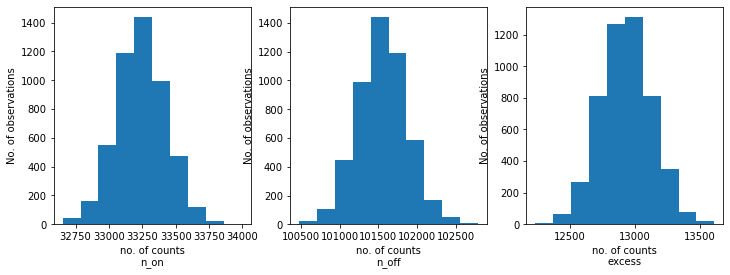

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 14min 6s, sys: 2.58 s, total: 14min 8s
Wall time: 14min 14s


In [15]:
results

[{'index': 2.232538916476606,
  'amplitude': 1.2373518606812286e-12,
  'lambda_': 0.44514007771400643},
 {'index': 2.1921386356870185,
  'amplitude': 1.3405471272444897e-12,
  'lambda_': 0.5539388397471491},
 {'index': 2.2390306532290274,
  'amplitude': 1.2114311723919235e-12,
  'lambda_': 0.481853635003571},
 {'index': 2.2381540033754255,
  'amplitude': 1.2512809290515709e-12,
  'lambda_': 0.5030039142543251},
 {'index': 2.241836083562033,
  'amplitude': 1.2686520335181529e-12,
  'lambda_': 0.5059561427729724},
 {'index': 2.1818599630503877,
  'amplitude': 1.3849873943605872e-12,
  'lambda_': 0.5523709213406991},
 {'index': 2.2361683329909523,
  'amplitude': 1.2748053201934255e-12,
  'lambda_': 0.4974112233182603},
 {'index': 2.2015748888965336,
  'amplitude': 1.3344334689422759e-12,
  'lambda_': 0.5278376715864108},
 {'index': 2.2232129757923187,
  'amplitude': 1.2387241715088374e-12,
  'lambda_': 0.45697540823556376},
 {'index': 2.257772560517059,
  'amplitude': 1.153001391526499e-1

index: 2.2196815824388594 += 0.022807678184521212


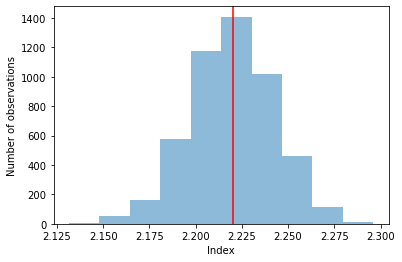

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2916382579659738e-12 += 6.352874012194479e-14


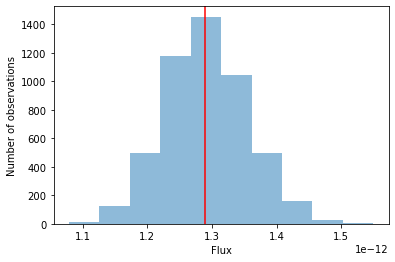

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.5010683265950256 += 0.03735410779052053


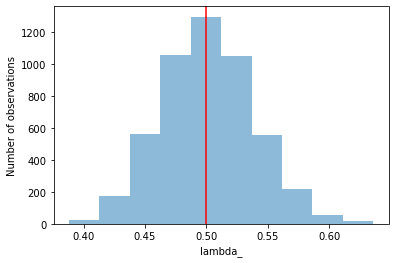

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")